Write your post here.

The CI algorithm:
$$ CI=Rrs\left(\lambda_{green}\right) - \big[Rrs\left(\lambda_{blue}\right) +\frac{\lambda_{green} - \lambda_{blue}}{\lambda_{red} -\lambda_{blue}} * \big(Rrs\left(\lambda_{red}\right) - Rrs\left(\lambda_{blue}\right)\big)\big]$$

The OCx algorithm:
$$ log_{10}\left(chlor_a\right) = a_0 + \sum_{i=1}^{4}a_ilog_{10}\left(\frac{Rrs\left(\lambda_{blue}\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import matplotlib.pyplot as pl
import pymc3 as pm
import pandas as pd
import seaborn as sb
import pickle
from sklearn.metrics import mean_squared_error, r2_score

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

In [3]:
%matplotlib inline

Define algorithms:

In [4]:
ocxCoeffs = [0.3272, -2.9940, 2.7218, -1.2259, -0.5683]
def CI(rgb, rrs_rgb):
    r,g,b = rgb
    rrsR, rrsG, rrsB = rrs_rgb
    ci = rrsG - (rrsB + (g - b) / (r - b) * (rrsR - rrsB))
    return ci

def OCx(ocxRatio, lin=False):
    if lin:
        ocxRatio = np.log10(ocxRatio)
    poly = np.sum([ocxCoeffs[i] * np.power((ocxRatio), i)
                  for i in range(1, 5) ], axis=0)
    poly+=ocxCoeffs[0]
    chl = np.power(10,poly)
    return chl

In [5]:
dfHu = pd.read_pickle('/accounts/ekarakoy/DATA/NOMAD/dfSwfHuOcxCI_2012.pkl')

In [6]:
dfHu['maxBlue'] = dfHu.loc[:,['rrs443', 'rrs490', 'rrs510']].max(axis=1)
dfHu['OCx_ratio'] = dfHu.maxBlue/dfHu['rrs555']
dfHu.head()

,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,id,depth,hplc_chl,sst,lat,lon,maxBlue,OCx_ratio
364,0.000719,0.000948,0.001301,0.001324,0.001442,0.000172,7733,4579.0,0.762,28.01,9.8309,-54.0398,0.001324,0.917677
365,0.000668,0.000919,0.001278,0.001336,0.001442,0.000148,7734,4711.0,0.653,26.86,13.0033,-55.9705,0.001336,0.926762
366,0.000568,0.000890,0.001350,0.001396,0.001471,0.000164,7735,2815.0,0.674,27.61,8.4358,-55.6672,0.001396,0.948457
367,0.000180,0.000421,0.000861,0.000944,0.001034,0.000127,7736,305.0,0.781,27.28,7.5592,-54.1950,0.000944,0.913254
368,0.000744,0.001134,0.001620,0.001552,0.001356,0.000094,7737,3738.0,0.409,27.29,9.5839,-55.6653,0.001552,1.144766


In [7]:
dfHu.describe()

,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,id,depth,hplc_chl,sst,lat,lon,maxBlue,OCx_ratio
count,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000
mean,0.005333,0.004681,0.004073,0.003224,0.002547,0.000598,6265.414815,2169.585185,1.956130,21.730148,12.277146,-72.853713,0.005097,2.558952
std,0.005380,0.003918,0.002107,0.001403,0.001922,0.001097,1907.193975,2019.316381,6.573409,6.965239,25.808243,53.173024,0.003698,2.309379
min,0.000051,0.000190,0.000422,0.000497,0.000639,0.000039,2640.000000,31.000000,0.017000,5.260000,-35.164400,-170.045000,0.000497,0.545438
25%,0.001390,0.001763,0.002406,0.002383,0.001573,0.000095,5906.000000,64.000000,0.148000,16.380000,-2.505000,-90.375900,0.002420,0.948595
50%,0.002829,0.002800,0.003402,0.003241,0.001858,0.000176,7227.000000,2815.000000,0.454000,25.540000,11.402300,-73.367000,0.003600,1.370997
75%,0.007855,0.007032,0.005820,0.003898,0.002630,0.000505,7316.000000,4306.500000,1.135500,27.290000,37.365100,-56.003650,0.007468,4.009556
max,0.022010,0.016246,0.009500,0.009600,0.012200,0.007900,7747.000000,5526.000000,53.002700,30.180000,43.619200,170.000000,0.016246,9.608322


In [8]:
dfHu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 364 to 4201
Data columns (total 14 columns):
rrs411       135 non-null float64
rrs443       135 non-null float64
rrs489       135 non-null float64
rrs510       135 non-null float64
rrs555       135 non-null float64
rrs670       135 non-null float64
id           135 non-null int32
depth        135 non-null float64
hplc_chl     135 non-null float64
sst          135 non-null float64
lat          135 non-null float64
lon          135 non-null float64
maxBlue      135 non-null float64
OCx_ratio    135 non-null float64
dtypes: float64(13), int32(1)
memory usage: 15.3 KB


Let's first confirm we're getting the plots right:    

In [9]:
ocxChl = OCx(dfHu.OCx_ratio,lin=True)

In [10]:
ci = CI([443,555,670],[dfHu.rrs443, dfHu.rrs555, dfHu.rrs670])
ciChl = np.power(10, -0.4909+191.6590 * ci)

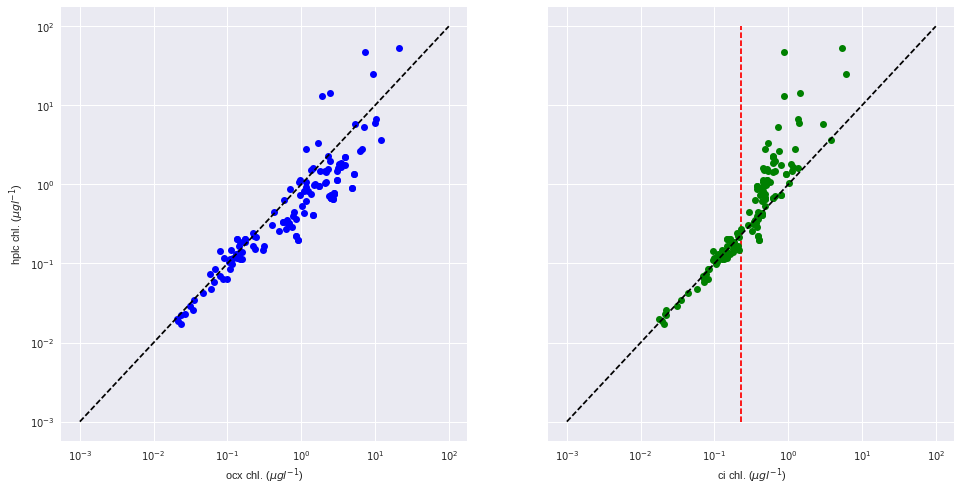

In [11]:
f,axs = pl.subplots(ncols=2, figsize=(16,8),sharey=True)
axs[0].loglog(ocxChl,dfHu.hplc_chl.values,'bo')
axs[0].loglog([1e-3, 1e2], [1e-3, 1e2], 'k--')
axs[0].set_ylabel('hplc chl. ($\mu gl^{-1}$)')
axs[0].set_xlabel('ocx chl. ($\mu gl^{-1}$)')
axs[1].loglog(ciChl, dfHu.hplc_chl.values, 'go')
axs[1].vlines(ciChl[ci<=-5e-4].max(),1e-3, 1e2,'r',linestyles='--', label='ci threshold($-5e^{-4}$)')
axs[1].loglog([1e-3, 1e2], [1e-3, 1e2], 'k--')
axs[1].set_xlabel('ci chl. ($\mu g l^{-1}$)')

Metrics for OCx

In [12]:
print("mse: %.2f " % mean_squared_error(dfHu.hplc_chl.values,ocxChl))
print(r"r^2: %.2f" % r2_score(dfHu.hplc_chl.values,ocxChl))

mse: 25.09 
r^2: 0.41


Hu *et al.* claims an $R^2$ of $0.95$ for CI-predicted Chl when CI $\leq -5e^{-4}$ while OC4 gave a 0.85 $R^2$ for the same points. a $-5e^{-4} corresponds ~ 4 $mg m^{-3} chl.

In [13]:
np.where(ci<=-5e-4,True,False).sum()

49

In [14]:
ciChl[ci<=-5e-4].max()

0.22867525333633054

I'll apply a log transformation here but note that there is a few 0-chlorophyll points. I'm going to first add a very low offset so I can take the log of the cholorophyll here.

In [15]:
dfHuLog = dfHu
dfHuLog = dfHu[['OCx_ratio', 'hplc_chl']].apply(lambda x: np.log10(x))

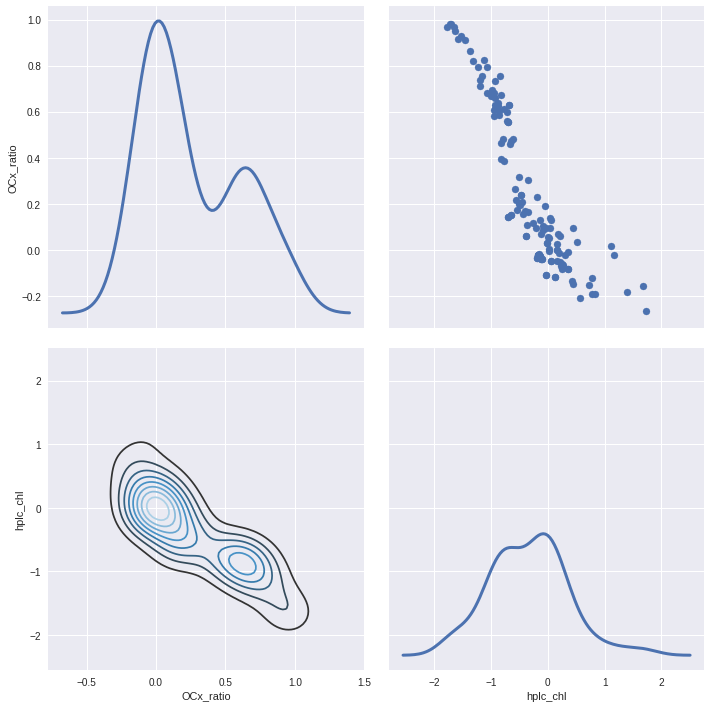

In [16]:
pg = sb.PairGrid(dfHuLog,size=5)
pg = pg.map_upper(pl.scatter)
pg = pg.map_lower(sb.kdeplot, cmap="Blues_d")
pg = pg.map_diag(sb.kdeplot, lw=3, legend=False)

In [17]:
dfHuLog.describe()

,OCx_ratio,hplc_chl
count,135.000000,135.000000
mean,0.260879,-0.338813
std,0.345334,0.675315
min,-0.263255,-1.769551
25%,-0.022919,-0.829748
50%,0.137037,-0.342944
75%,0.603091,0.055172
max,0.982648,1.724298


In [18]:
loChlCount = dfHuLog.loc[dfHuLog.hplc_chl<np.log10(0.25)].count()
hiChlCount = dfHuLog.loc[dfHuLog.hplc_chl>=np.log10(0.25),:].shape[0]

In [19]:
loChlCount, hiChlCount

(OCx_ratio    52
 hplc_chl     52
 dtype: int64, 83)

In [20]:
ocxRatio = dfHuLog.OCx_ratio
chlObs = dfHuLog.hplc_chl

In [21]:
with pm.Model() as model_OCx:
    a0 = pm.Normal('a0', mu=0, sd=10)
    a1 = pm.Normal('a1', mu=0, sd=10)
    a2 = pm.Normal('a2', mu=0, sd=10)
    a3 = pm.Normal('a3', mu=0, sd=10)
    a4 = pm.Normal('a4', mu=0, sd=10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    mu = a0 + a1 * ocxRatio + a2 * ocxRatio**2 + a3 * ocxRatio**3 + a4 * ocxRatio**4
    chlPred = pm.Normal('chlPred', mu=mu, sd=epsilon, observed=chlObs)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    traceOCx = pm.sample(10000, step=step, start=start)

Applied interval-transform to epsilon and added transformed epsilon_interval_ to model.
100%|██████████| 10000/10000 [00:46<00:00, 214.56it/s]


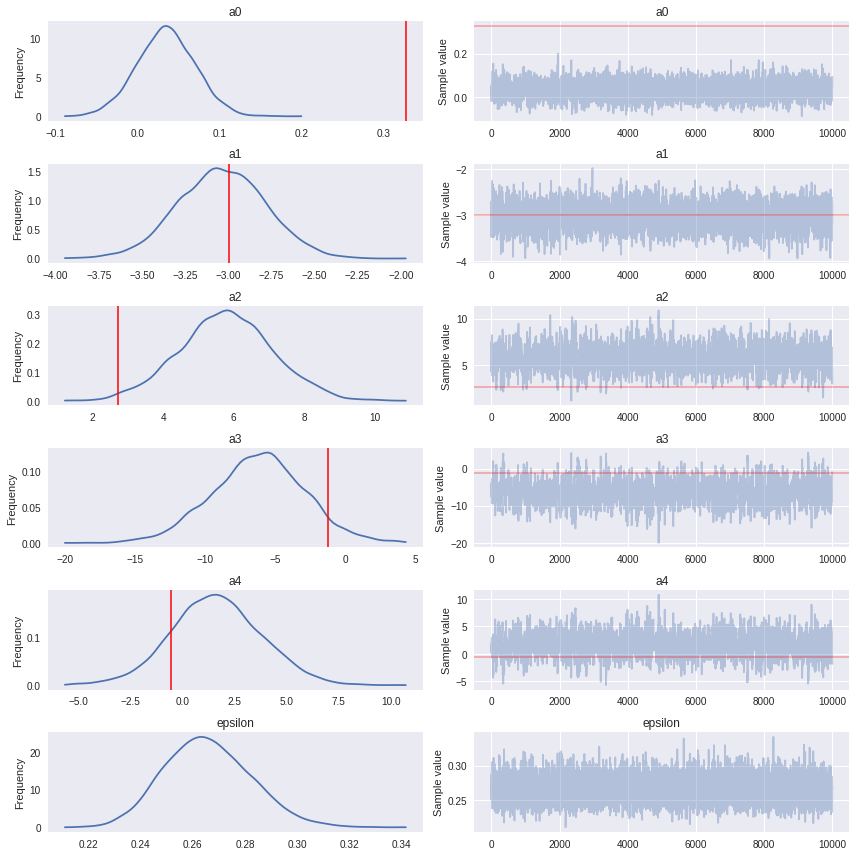

In [81]:
chainOCx = traceOCx[1000:]
varnames=['a%d' %d for d in range(5)]
varnames.append('epsilon')
refvals = {'a%d' %d: rv for d,rv in zip(range(5), ocxCoeffs) }
pm.traceplot(traceOCx,varnames=varnames,lines=refvals);

In [82]:
pm.df_summary(chainOCx, varnames=varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a0,0.034525,0.035389,0.000719,-0.034937,0.104589
a1,-3.035998,0.251627,0.003866,-3.519370,-2.531362
a2,5.819708,1.315686,0.039520,3.358993,8.543294
a3,-6.276359,3.295409,0.105988,-12.735481,0.161727
a4,1.667018,2.163548,0.068342,-2.590834,5.945776
epsilon,0.265783,0.016588,0.000192,0.234489,0.298550


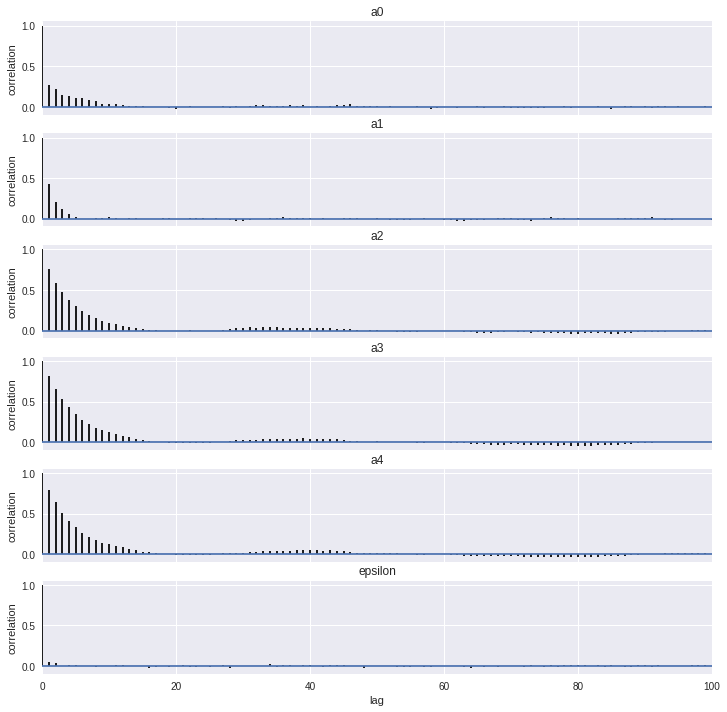

In [83]:
pm.autocorrplot(chainOCx, varnames=varnames);

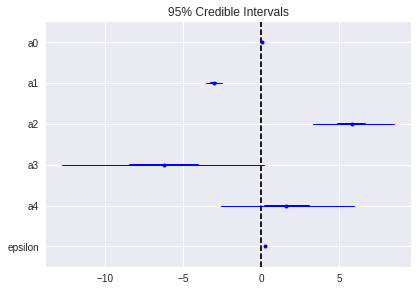

In [84]:
pm.forestplot(chainOCx,varnames=varnames)

In [ ]:
sb.set(rc=rc)

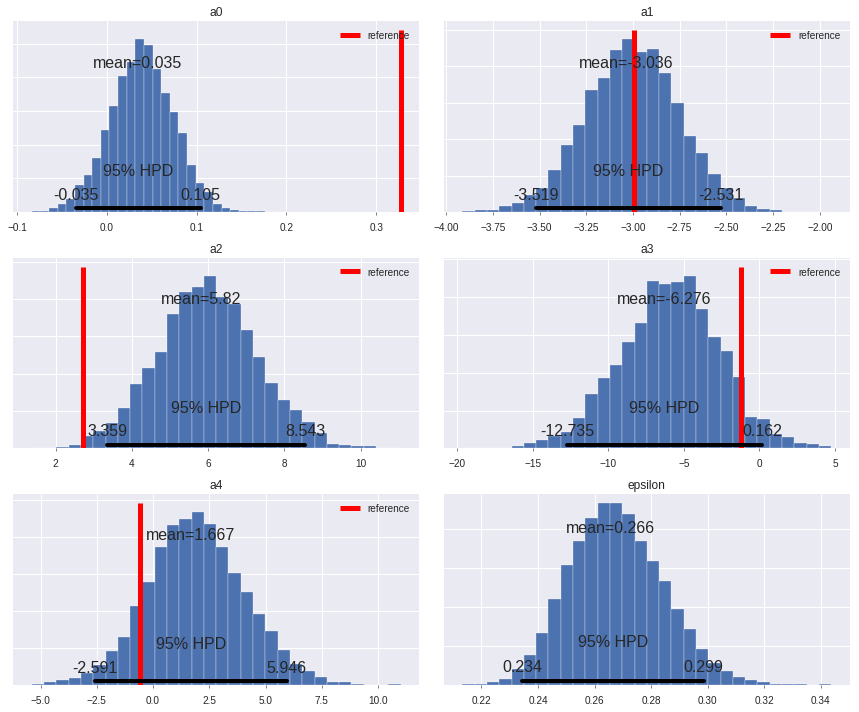

In [85]:
axs=pm.plot_posterior(chainOCx,varnames=varnames, figsize=(12,10))
for ax,rv in zip(axs.ravel(),ocxCoeffs):
    ax.vlines(rv,0,ax.get_ylim()[1], colors='r', linewidth=5, label='reference')
    ax.legend()

In [86]:
chlModl=0
ocxRatioMock = np.linspace(ocxRatio.min(),ocxRatio.max(),100)
for i in range(5):
    chlModl+= ocxCoeffs[i]*ocxRatioMock**i

In [87]:
chlBayes=0
for i in range(5):
    chlBayes += chainOCx['a%d' %i].mean()*ocxRatioMock**i

In [104]:
idx = np.argsort(ocxRatio.values)
ocxRatio_ord = ocxRatio.values[idx]
ppc = pm.sample_ppc(chainOCx, samples=1000, model=model_OCx)
sig0 = pm.hpd(ppc['chlPred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['chlPred'], alpha=0.05)[idx]

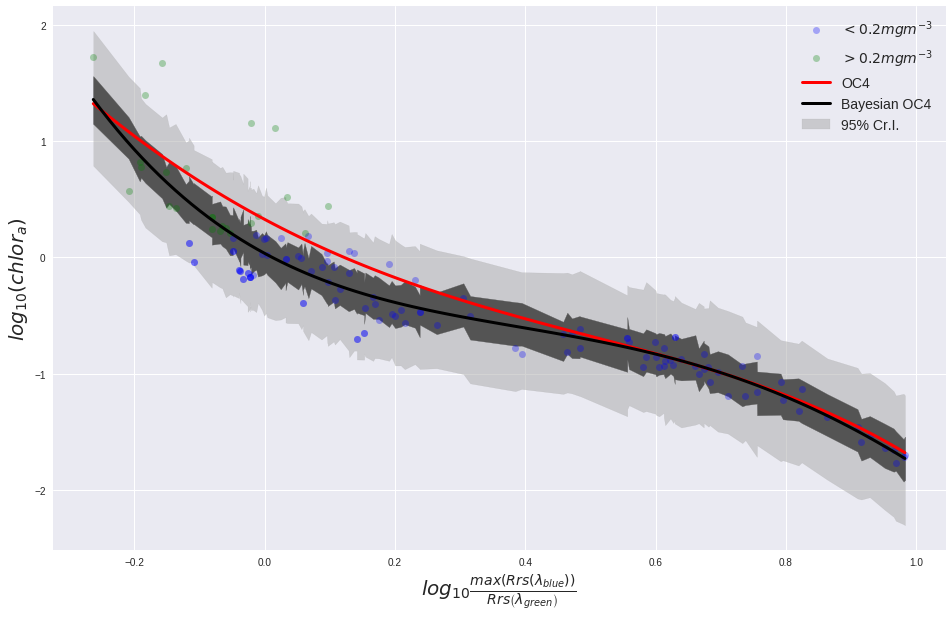

In [111]:
pl.figure(figsize=(16,10))
pl.fill_between(ocxRatio_ord, sig0[:,0], sig0[:,1], color='k', alpha=1)
pl.fill_between(ocxRatio_ord, sig1[:,0], sig1[:,1], color='darkgray', alpha=0.5, label='95% Cr.I.')
pl.plot(ocxRatio[chlObs<=.2],chlObs[chlObs<=.2],'bo',alpha=0.3, label='$<0.2mg m^{-3}$')
pl.plot(ocxRatio[chlObs>.2],chlObs[chlObs>.2],'go',alpha=0.3, label='$>0.2mg m^{-3}$')
pl.plot(ocxRatioMock,chlModl,'r', linewidth=3, label='OC4')
pl.plot(ocxRatioMock,chlBayes,'k', linewidth=3, label='Bayesian OC4')
pl.xlabel(r'$log_{10}\frac{max(Rrs\left(\lambda_{blue}\right))}{Rrs\left(\lambda_{green}\right)}$', fontsize=20)
pl.ylabel(r'$log_{10}\left(chlor_a\right)$', fontsize=20);
pl.legend(fontsize=14);

Let's calculate metrics for this model

In [116]:
chlBayesReal=0
for i in range(5):
    chlBayesReal += chainOCx['a%d' %i].mean()*ocxRatio**i
chlBayesReal = np.power(10, chlBayesReal)

In [117]:
print("OCx Chl mse: %.2f " % mean_squared_error(dfHu.hplc_chl.values,ocxChl))
print("Bayes Chl mse: %.2f" % mean_squared_error(dfHu.hplc_chl.values,chlBayesReal))
print("OCx Chl r^2: %.2f" % r2_score(dfHu.hplc_chl.values,ocxChl))
print("Bayes Chl r^2: %.2f" % r2_score(dfHu.hplc_chl.values, chlBayesReal))

OCx Chl mse: 25.09 
Bayes Chl mse: 25.42
OCx Chl r^2: 0.41
Bayes Chl r^2: 0.41


What about for low values, how is that performing, e.g. relative to ci CHl?
What about a test set how do both models compare on an unseen dataset?

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()